## Data Preparation<a class="anchor" id="data_preparation"></a>

In [93]:
import warnings

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, InputLayer, Reshape, Conv2DTranspose

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import numpy as np
import tensorflow as tf

import imgaug as ia
import imgaug.augmenters as iaa

tf.get_logger().setLevel(3)
import cv2
import os, glob
import pandas as pd

In [94]:
DATASET_PATH = r"./dataset/"
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
EPOCHS = 30
BATCH_SIZE = 32
SEED = 42
dataset_folders = []  # to keep main folder names
total = 0
print(f"There are {len(os.listdir(DATASET_PATH))} folder in dataset.")
for path in sorted(os.listdir(DATASET_PATH)):
    print(f"\t-There are {len(os.listdir(DATASET_PATH + path))} images in {path} folder.")
    total += len(os.listdir(DATASET_PATH + path))  # add element size of the current folder to total variable
    dataset_folders.append(DATASET_PATH + path)  # add current folder path to dataset_folders

# Create an empty dataframe
df = pd.DataFrame(0,
                  columns=['paths',
                           'class_label'],
                  index=range(total))
# store each image path in the dataframe
# class labels -> 0:Normal 1:Cataract 2:Glaucoma 3:RetinaDisease
i = 0
for p, path in enumerate(dataset_folders):  # main folders
    for sub_path in sorted(os.listdir(path)):  #images
        df.iloc[i, 0] = path + "/" + sub_path
        df.iloc[i, 1] = p
        i += 1
# Display some examples for the created DataFrame
# print(df.sample(frac=1, random_state=SEED).head(10))
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df['class_label'])

There are 4 folder in dataset.
	-There are 300 images in 1_normal folder.
	-There are 100 images in 2_cataract folder.
	-There are 101 images in 2_glaucoma folder.
	-There are 100 images in 3_retina_disease folder.


In [95]:
example_paths = [DATASET_PATH + "1_normal/NL_001.png", DATASET_PATH + "2_cataract/cataract_001.png",
                 DATASET_PATH + "2_glaucoma/Glaucoma_001.png", DATASET_PATH + "3_retina_disease/Retina_001.png"]
images_array1 = []
images_array2 = []


def display_examples(images_array1, images_array2, row1, row2, channel=3):
    fig = plt.figure(figsize=(15, 9))
    plt.title(f"First row->{row1} Images    Second row->{row2} Images")
    plt.axis('off')
    plt.grid(False)
    for i in range(4):
        current_path = example_paths[i]

        fig.add_subplot(2, 4, i + 1)
        plt.axis('off')
        plt.title(current_path.split("/")[3])
        plt.imshow(images_array1[i])

        fig.add_subplot(2, 4, i + 5)
        plt.axis('off')
        plt.title(current_path.split("/")[3])
        if channel == 1:
            plt.imshow(images_array2[i], cmap='gray')
        else:
            plt.imshow(images_array2[i])

## Initial preprocess
Our first preprocessing method is applied in every iteration since the outcome is the stripping of unnecessary data.

In this preprocess, we delete unnecessary black areas from the images. Also we resize the images to 128x128 due to huge dimensions and to feed our model with a standard image shape.


In [96]:
#Cropping image to avoid from unnecessary black areas
def deleteBlackAreas(filename):
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
    img = cv2.imread(filename)  #read image from file
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)  # turn it into a binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # find contours
    if len(contours) != 0:
        #find the biggest area
        cnt = max(contours, key=cv2.contourArea)

        #find the bounding rect
        x, y, w, h = cv2.boundingRect(cnt)

        crop = img[y:y + h, x:x + w]  # crop image
        crop1 = cv2.cvtColor(cv2.resize(crop, image_size, interpolation=cv2.INTER_AREA),
                             cv2.COLOR_BGR2RGB)  # resize to image_size and change color space from BGR to RGB for matplotlib
        return crop1
    else:
        return cv2.cvtColor(cv2.resize(img, image_size, interpolation=cv2.INTER_AREA), cv2.COLOR_BGR2RGB)

## Create Dataset and Augmentation Functions

In [97]:
def create_dataset(df, type=0):  #0->float32 1->uint8
    # Creating dataset
    images = []
    labels = []
    index = 0
    for path in tqdm(df['paths']):
        #According to parameter, we apply some preprocesses here. default=0
        img = deleteBlackAreas(path)  #deleting black areas. Initial preprocess
        label = [0, 0, 0, 0]
        label[df.iloc[index]["class_label"]] += 1
        index += 1
        images.append(img)
        labels.append(label)
    if type == 0:
        images = np.array(images, dtype='float32') / 255
    elif type == 1:
        images = np.array(images, dtype='uint8')
    labels = np.array(labels)
    return augmentation(images, labels)

def augmentation(images, labels):
    ia.seed(42)

    contrast = iaa.Sequential([
        iaa.Sometimes(
            0.3,
            iaa.GaussianBlur(sigma=(0, 0.25))
        ),
        iaa.LinearContrast((0.75, 1.5)),
    ])

    mix = iaa.Sequential([
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.25))
        ),
        iaa.Sometimes(
            0.5,
            iaa.LinearContrast((0.75, 1.5)),
        ),
        iaa.Affine(
            scale={"x": (0.8, 1), "y": (0.8, 1)},
            #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-20, 20),
            #shear=(-2, 2)
        )
    ], random_order=True)  # apply augmenters in random order

    augmentation_dict = {0: contrast, 1: mix}
    images_result = None
    labels_result = None
    seeds = [6, 37]
    for i in range(len(augmentation_dict)):
        func = augmentation_dict[i]
        if i == 0:
            images_augmented = func(images=images)
            images_result = np.concatenate((images, images_augmented))
            labels_result = np.concatenate((labels, labels))
        elif i == 1:
            for k in range(1):
                ia.seed(seeds[k])
                images_augmented = func(images=images)
                images_result = np.concatenate((images_result, images_augmented))
                labels_result = np.concatenate((labels_result, labels))
    return images_result, labels_result

In [98]:
# Creating dataset and split the data
train_images, train_labels = create_dataset(train_df)
test_images, test_labels = create_dataset(test_df)
labels = ["Normal", "Cataract", "Glaucoma", "Retina Disease"]


100%|██████████| 121/121 [00:09<00:00, 13.15it/s]


In [99]:
X_train, y_train = train_images, train_labels
X_test, y_test = test_images, test_labels

In [100]:
print(f"X train shape -> {X_train.shape}")
print(f"X test shape -> {X_test.shape}")
print(f"Y train shape -> {np.array(y_train).shape}")
print(f"Y test shape -> {np.array(y_test).shape}")

X train shape -> (1440, 128, 128, 3)
X test shape -> (363, 128, 128, 3)
Y train shape -> (1440, 4)
Y test shape -> (363, 4)


In [101]:
train1, train2 = np.split(X_train, 2)
print(len(X_train), len(train1), len(train2))

1440 720 720


In [102]:
encoding_dim = 1024
encoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(128, 128, 3)),
        Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
        Flatten(),
        Dense(encoding_dim, )
    ])
print(encoder_net.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 512)       1049088   
                                                                 
 flatten_1383 (Flatten)      (None, 131072)            0         
                                                                 
 dense_12 (Dense)            (None, 1024)              134218752 
                                                                 
Total params: 135,402,176
Trainable params: 135,402,176
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
dense_dim = [16, 16, 512]
decoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(encoding_dim,)),
        Dense(np.prod(dense_dim)),
        Reshape(target_shape=dense_dim),
        Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
    ])
print(decoder_net.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 131072)            134348800 
                                                                 
 reshape_3 (Reshape)         (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 32, 32, 256)      2097408   
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 64, 64, 64)       262208    
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 128, 128, 3)      3075      
 Transpose)                                                      
                                                      

In [104]:
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

od = OutlierVAE(
    threshold=0.15,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=1024,
    samples=4
)

In [105]:
adam = tf.keras.optimizers.Adam(lr=1e-4)
od.fit(X_train,
       optimizer=adam,
       epochs=10,
       batch_size=64,
       verbose=True)

23/23 [=] - 73s 3s/step - loss_ma: -56609.9152


In [106]:
od.infer_threshold(X_test, outlier_type='instance', threshold_perc=99.0)
print("Current th: ", od.threshold)

Current th:  0.016516042631119474


In [107]:
od_preds_test = od.predict(X_test,
                           outlier_type='instance',
                           return_feature_score=True,
                           return_instance_score=True
                           )

In [108]:
print(list(od_preds_test['data'].keys()))

['instance_score', 'feature_score', 'is_outlier']


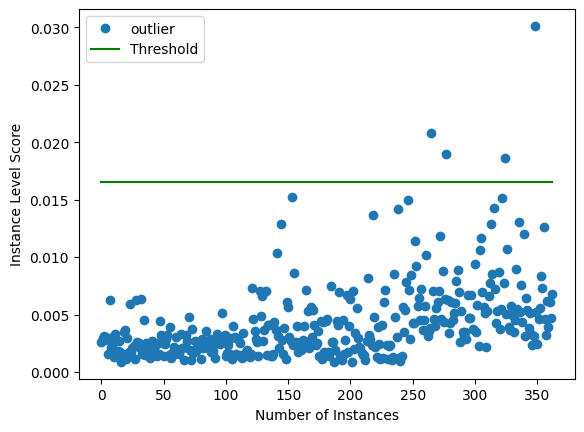

In [109]:
target = np.ones(X_test.shape[0], ).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds_test, target, labels, od.threshold)  #pred, target, labels, threshold

In [110]:
outlier_indexes_test = []
for i in range(len(X_test)):
    if od_preds_test['data']['instance_score'][i] > od.threshold:
        outlier_indexes_test.append(i)
print("Outlier indexes: ", outlier_indexes_test)

Outlier indexes:  [265, 277, 324, 348]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


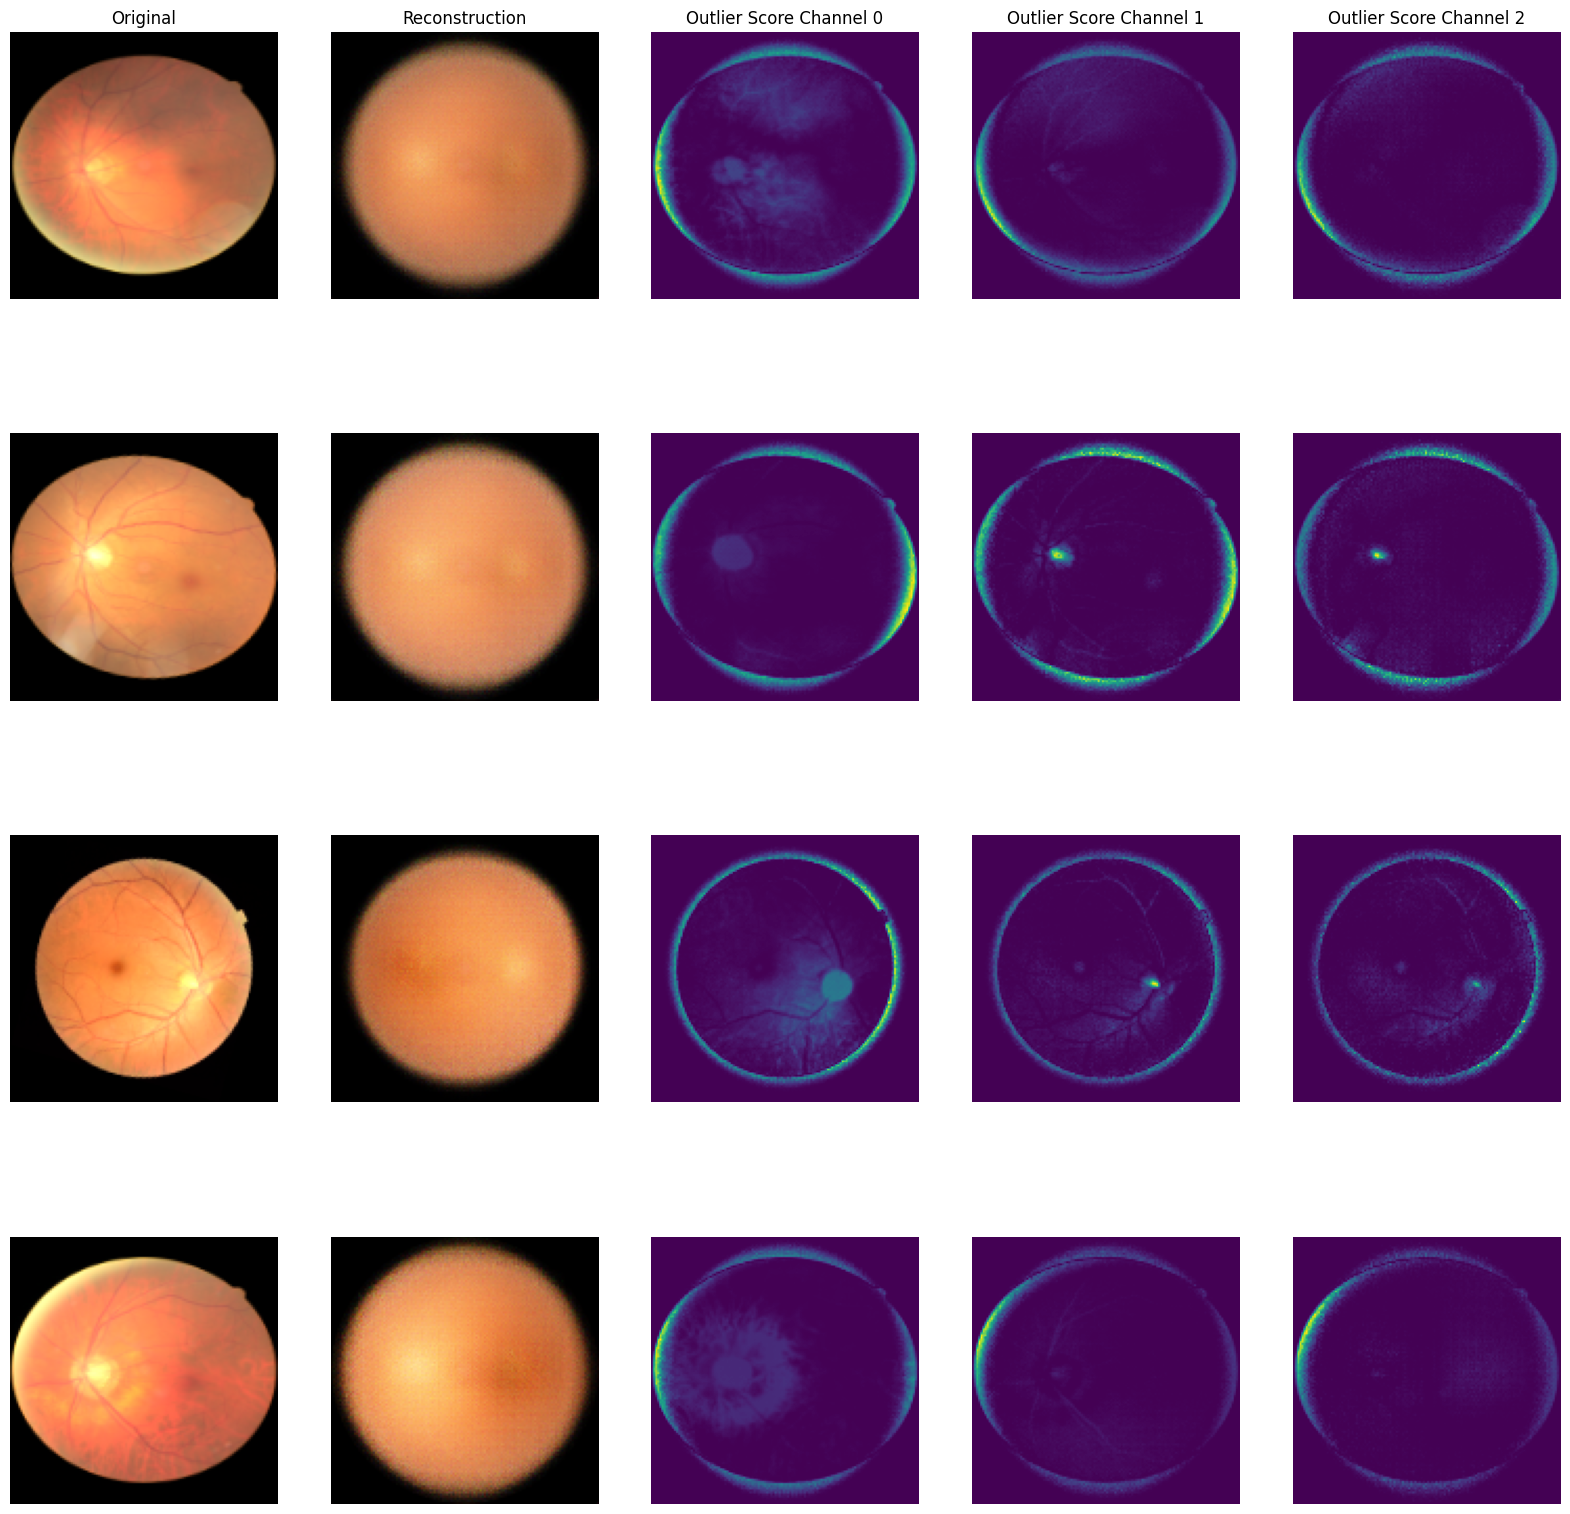

In [111]:
if len(outlier_indexes_test) != 0:
    #Plot features for select images, using the built in function (plot_feature_outlier_image)
    X_recon = od.vae(X_test).numpy()
    plot_feature_outlier_image(od_preds_test,
                               X_test,
                               X_recon=X_recon,
                               instance_ids=outlier_indexes_test,  # pass a list with indices of instances to display
                               max_instances=len(outlier_indexes_test),  # max nb of instances to display
                               outliers_only=False)  # only show outlier predictions

In [112]:
od_preds_train1 = od.predict(train1,
                             outlier_type='instance',
                             return_feature_score=True,
                             return_instance_score=True
                             )

In [113]:
od_preds_train2 = od.predict(train2,
                             outlier_type='instance',
                             return_feature_score=True,
                             return_instance_score=True
                             )

In [114]:
target1 = np.ones(train1.shape[0], ).astype(int)  # Ground truth (all ones for bad images)
target2 = np.ones(train2.shape[0], ).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']

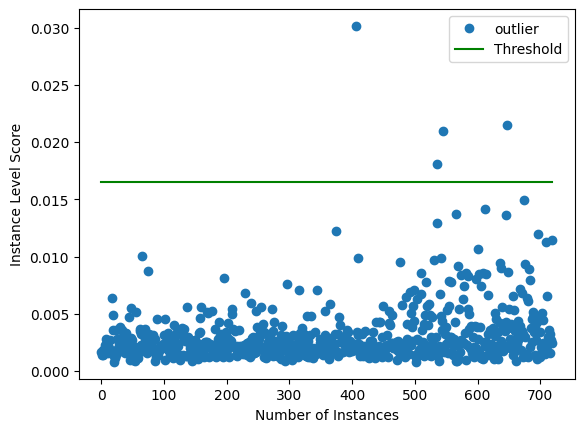

In [115]:
plot_instance_score(od_preds_train1, target1, labels, od.threshold)  #pred, target, labels, threshold

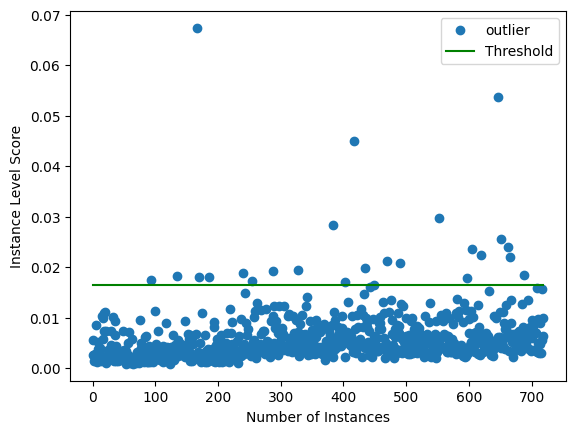

In [116]:
plot_instance_score(od_preds_train2, target2, labels, od.threshold)  #pred, target, labels, threshold

In [124]:
outlier_indexes_train1 = []
outlier_indexes_train2 = []
outlier_indexes_train=[]
for i in range(len(train1)):
    if od_preds_train1['data']['instance_score'][i] > od.threshold:
        outlier_indexes_train1.append(i)
        outlier_indexes_train.append(i)
for i in range(len(train2)):
    if od_preds_train2['data']['instance_score'][i] > od.threshold:
        outlier_indexes_train2.append(i)
        outlier_indexes_train.append((i+len(train1)))
print("Outlier indexes for train1: ", outlier_indexes_train1)
print("Outlier indexes for train2: ", outlier_indexes_train2)
print("Outlier indexes: ", outlier_indexes_train)

Outlier indexes for train1:  [406, 536, 545, 647]
Outlier indexes for train2:  [93, 135, 166, 169, 186, 240, 255, 288, 328, 383, 403, 417, 435, 469, 491, 553, 597, 605, 619, 646, 652, 663, 666, 688]
Outlier indexes:  [406, 536, 545, 647, 813, 855, 886, 889, 906, 960, 975, 1008, 1048, 1103, 1123, 1137, 1155, 1189, 1211, 1273, 1317, 1325, 1339, 1366, 1372, 1383, 1386, 1408]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


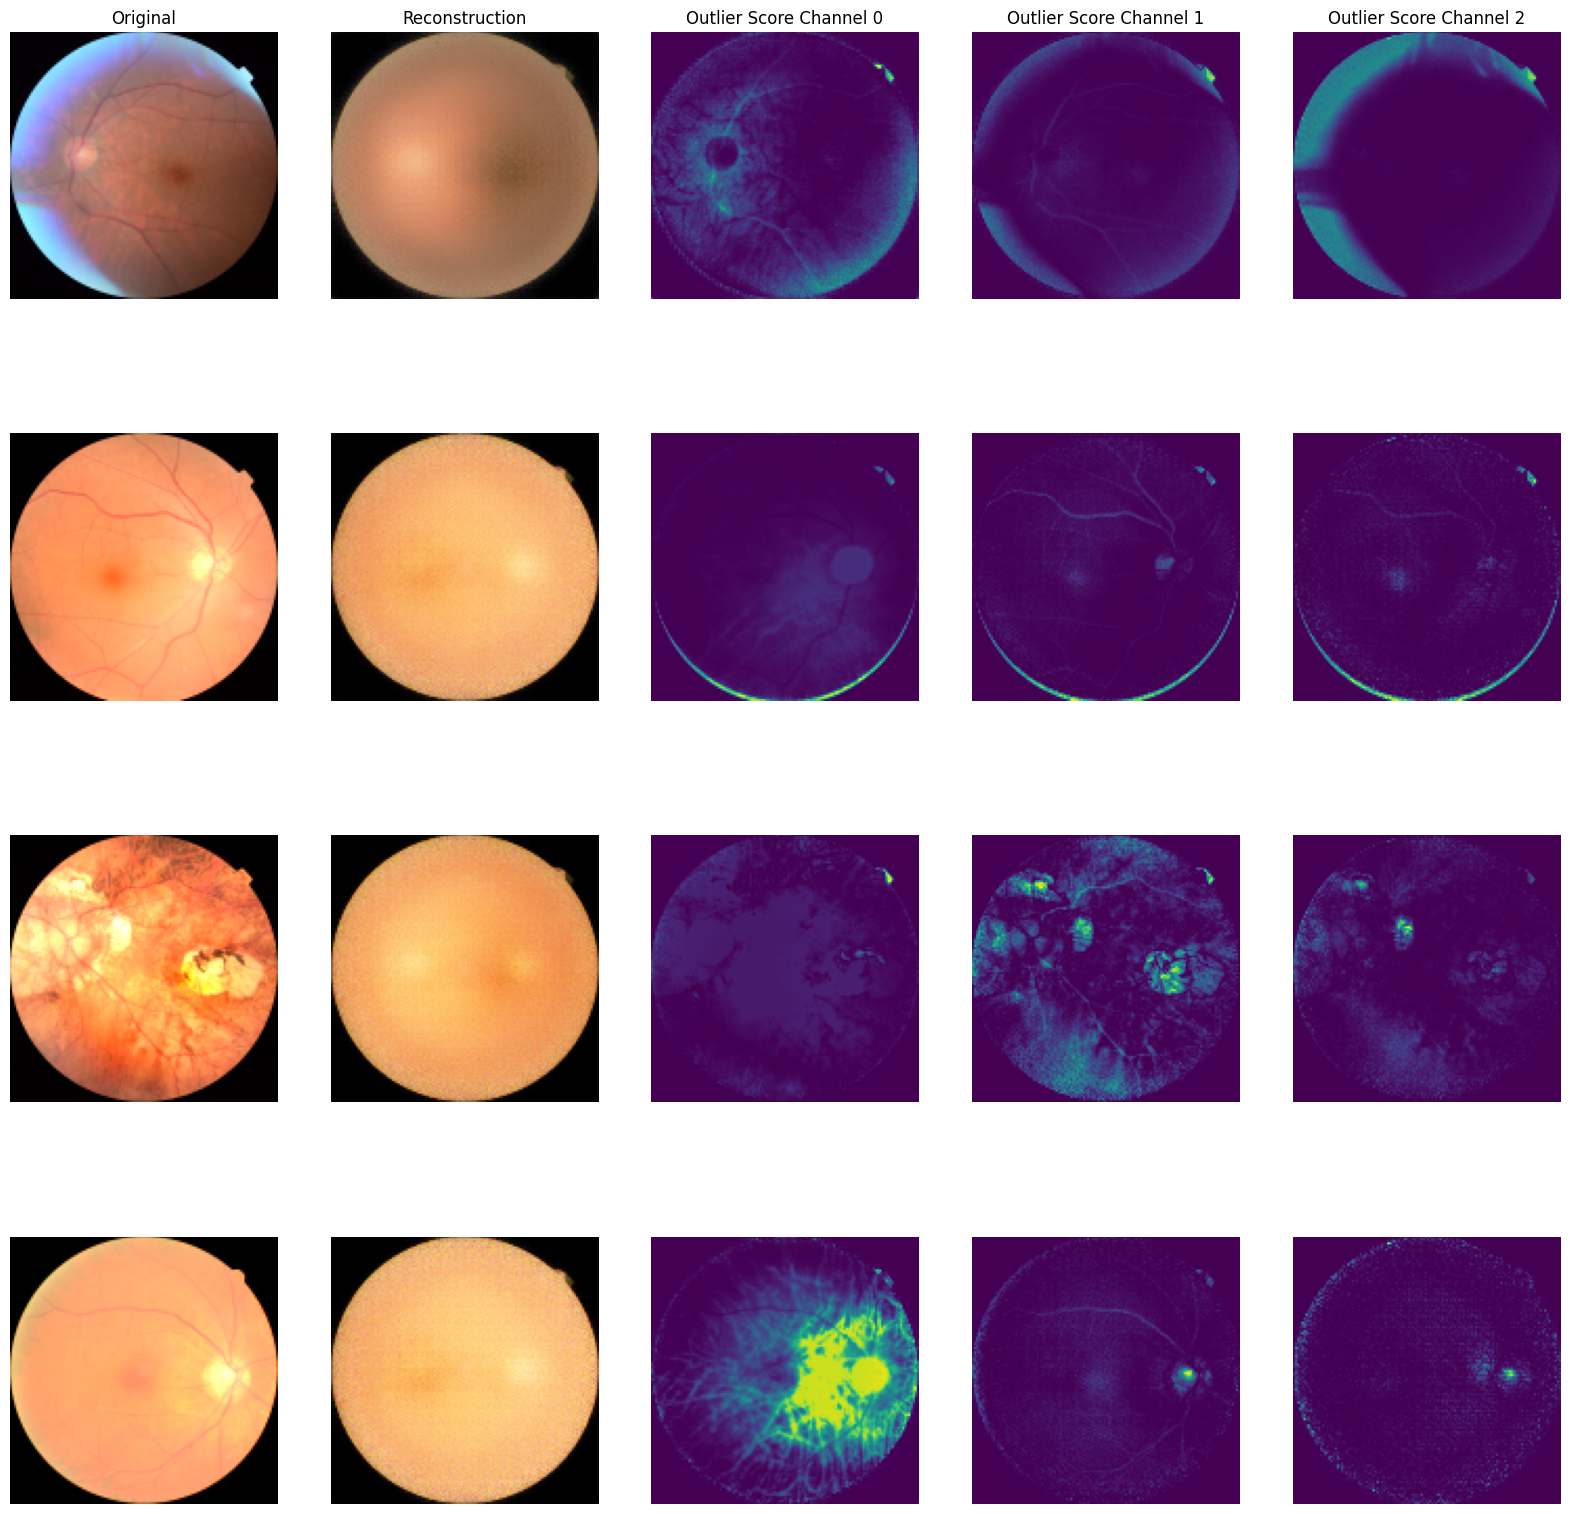

In [118]:
if len(outlier_indexes_train1) != 0:
    #Plot features for select images, using the built in function (plot_feature_outlier_image)
    X_recon1 = od.vae(train1).numpy()
    plot_feature_outlier_image(od_preds_train1,
                               train1,
                               X_recon=X_recon1,
                               instance_ids=outlier_indexes_train1,  # pass a list with indices of instances to display
                               max_instances=len(outlier_indexes_train1),  # max nb of instances to display
                               outliers_only=False)  # only show outlier predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

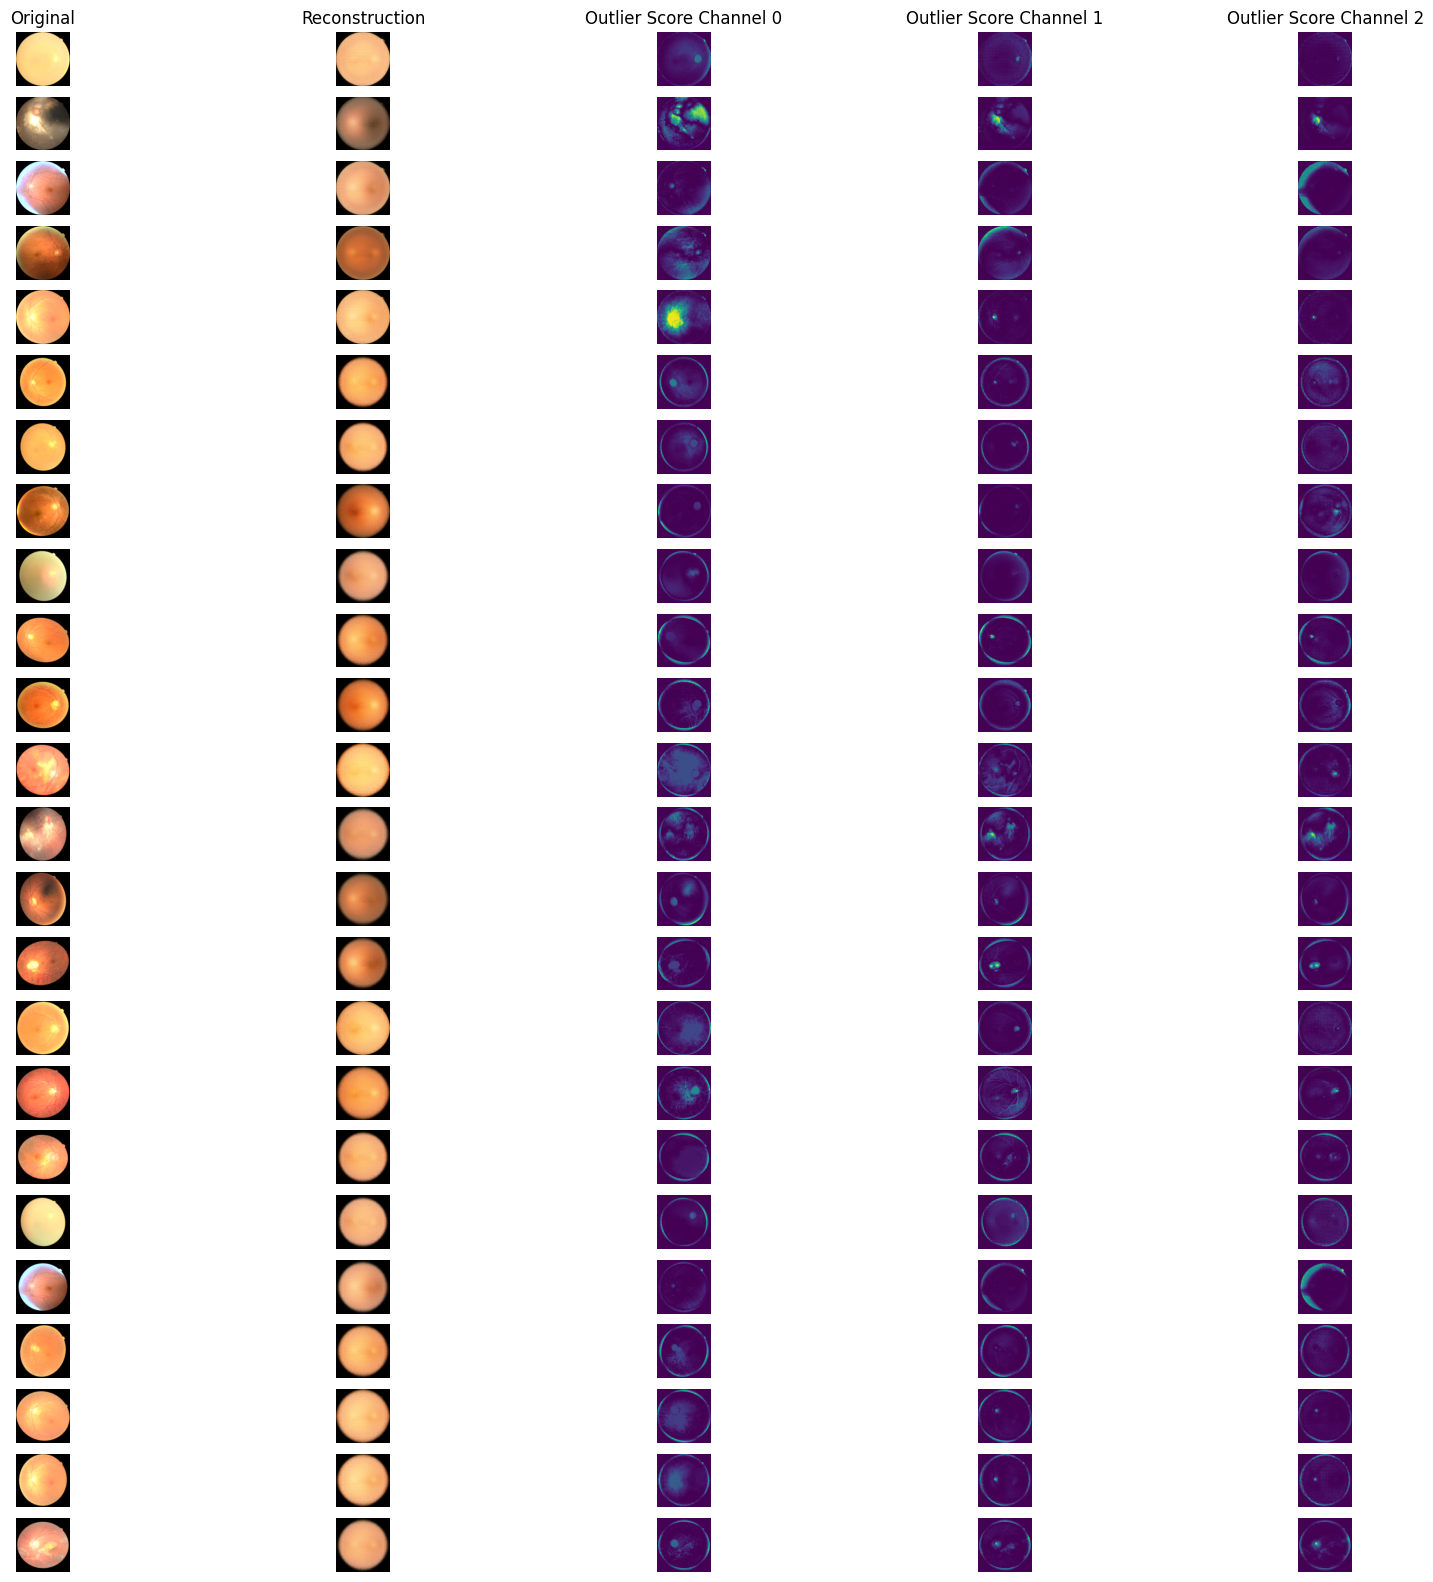

In [119]:
if len(outlier_indexes_train2) != 0:
    #Plot features for select images, using the built in function (plot_feature_outlier_image)
    X_recon2 = od.vae(train2).numpy()
    plot_feature_outlier_image(od_preds_train2,
                               train2,
                               X_recon=X_recon2,
                               instance_ids=outlier_indexes_train2,  # pass a list with indices of instances to display
                               max_instances=len(outlier_indexes_train2),  # max nb of instances to display
                               outliers_only=False)  # only show outlier predictions

# Creating dataset and split the data
train_images, train_labels = create_dataset(train_df,type=1)
test_images, test_labels = create_dataset(test_df,type=1)
labels = ["Normal", "Cataract", "Glaucoma", "Retina Disease"]

X_train, y_train = train_images, train_labels
X_test, y_test = test_images, test_labels

train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)
indexes = [0, 0, 0, 0]
label_map = {0: "normal", 1: "cataract", 2: "glaucoma", 3: "retina_disease"}
for i in range(len(X_train)):
    if i in outlier_indexes_train:
        continue
    length = len(str(indexes[train_labels[i]]))
    file_name = (4 - length) * "0" + str(indexes[train_labels[i]]) + ".png"
    to_path = r"./dataset_with_aug/" + label_map[train_labels[i]] + "/" + file_name
    cv2.imwrite(to_path, cv2.cvtColor(X_train[i], cv2.COLOR_RGB2BGR))
    indexes[train_labels[i]] += 1

for i in range(len(X_test)):
    if i in outlier_indexes_test:
        continue
    length = len(str(indexes[test_labels[i]]))
    file_name = (4 - length) * "0" + str(indexes[test_labels[i]]) + ".png"
    to_path = r"./dataset_with_aug/" + label_map[test_labels[i]] + "/" + file_name
    cv2.imwrite(to_path, cv2.cvtColor(X_test[i], cv2.COLOR_RGB2BGR))
    indexes[test_labels[i]] += 1

In [145]:
print(f"X_train: {X_train.shape} --- y_train: {y_train.shape}\nX_test: {X_test.shape} --- y_test: {y_test.shape}")

X_train: (1440, 128, 128, 3) --- y_train: (1440, 4)
X_test: (363, 128, 128, 3) --- y_test: (363, 4)


In [146]:
outlier_indexes_train.sort(reverse=1)
outlier_indexes_test.sort(reverse=1)
for index in outlier_indexes_train:
    X_train= np.delete(X_train,index,axis=0)
    y_train= np.delete(y_train,index,axis=0)
for index in outlier_indexes_test:
    X_test= np.delete(X_test,index,axis=0)
    y_test= np.delete(y_test,index,axis=0)


In [147]:
print(f"X_train: {X_train.shape} --- y_train: {y_train.shape}\nX_test: {X_test.shape} --- y_test: {y_test.shape}")

X_train: (1412, 128, 128, 3) --- y_train: (1412, 4)
X_test: (359, 128, 128, 3) --- y_test: (359, 4)
